In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mmohaiminulislam/vehicles-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ivand\.cache\kagglehub\datasets\mmohaiminulislam\vehicles-image-dataset\versions\1


In [3]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from glob import glob
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix

C:\Users\ivand\.cache\kagglehub\datasets\mmohaiminulislam\vehicles-image-dataset\versions\1\vehicle_data
Dataset found.
Train and validation dataloaders created.
Class distribution: {'airplane': 133, 'ambulance': 153, 'bicycle': 151, 'boat': 171, 'bus': 165, 'car': 166, 'fire_truck': 174, 'helicopter': 172, 'hovercraft': 178, 'jet_ski': 167, 'kayak': 169, 'motorcycle': 174, 'rickshaw': 163, 'scooter': 150, 'segway': 159, 'skateboard': 156, 'tractor': 159, 'truck': 148, 'unicycle': 149, 'van': 169}


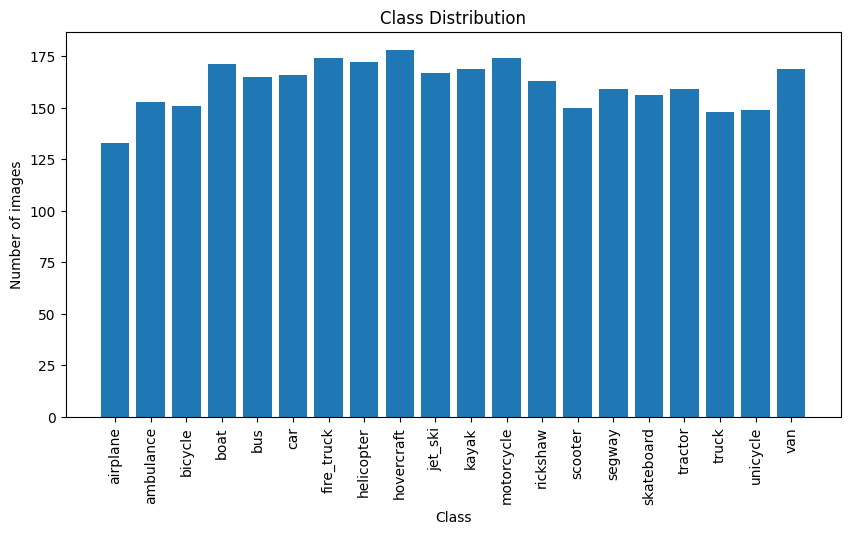

In [5]:

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Verificar si el directorio existe
        if not os.path.exists(root):
            raise FileNotFoundError(f"El directorio {root} no existe.")
        # Verificar si hay imágenes en el directorio
        if not glob(f"{root}/*/*jpg"):
            raise FileNotFoundError(f"No se encontraron imágenes en el directorio {root}.")
        # Verificar si hay subdirectorios
        if len(glob(f"{root}/*")) == 0:
            raise FileNotFoundError(f"No se encontraron subdirectorios en el directorio {root}.")

        
        # Obtener todas las imágenes en el directorio
        self.paths = [path for path in sorted(glob(f"{root}/*/*jpg"))]
        self.class_names = {}
        self.class_counts = {}
        self.class_to_idx = {}
        self.idx_to_class = {}  
        count = 0
        data_count = 0

        class_names = sorted({os.path.normpath(path).split(os.sep)[-2] for path in self.paths})
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        self.idx_to_class = {i: cls_name for i, cls_name in enumerate(class_names)}

        for idx, path in enumerate(self.paths):
            class_name = os.path.normpath(path).split(os.sep)[-2]  # Obtener el nombre de la clase del directorio
            # Asignar un índice a cada clase
            if class_name not in self.class_names:
                self.class_names[class_name] = count # Asignar un índice único a la clase
                self.class_counts[class_name] = 1 # Inicializar el conteo de la clase
                count += 1
            else:
                self.class_counts[class_name] += 1 # Incrementar el conteo de la clase

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")
        idx = self.class_names[os.path.normpath(path).split(os.sep)[-2]]  # Obtener el índice de la clase
        if self.transforms:
            image = self.transforms(image)
        return image, idx
    
    def get_class_distribution(self):
        return self.class_counts

    
def get_dataloader(root, transform, batch_size=32, num_workers=4, split = [0.9, 0.05, 0.05]):
    
    # Crear el dataset y los dataloaders
    full_dataset = CustomDataset(root=root, transforms=transform)

    # Dividir el dataset en entrenamiento y validación    
    total_size = len(full_dataset)
    train_size = int(total_size * split[0])
    val_size = int(total_size * split[1])
    test_size = total_size - train_size - val_size

    # Asegurarse de que la suma de los tamaños sea igual al tamaño total
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Verificar si los tamaños son correctos
    if len(train_dataset) + len(val_dataset) + len(test_dataset) != total_size:
        raise ValueError("Los tamaños de los datasets no suman el tamaño total del dataset.")

    # Crear los dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader, full_dataset.idx_to_class

print(path)
if path is not None:
    # Check if the dataset is downloaded
    if not os.path.exists(path):
        print("Dataset not found. Please check the path.")
    else:
        print("Dataset found.")

if not path.endswith("vehicle_data"):
    path = path + "\\vehicle_data"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get the dataloaders   
train_loader, val_loader, test_loader, class_names = get_dataloader(path, transform, batch_size=32, num_workers=4, split=[0.9, 0.05, 0.05])
print("Train and validation dataloaders created.")

# Check the class distribution
dataset = CustomDataset(root=path)
class_distribution = dataset.get_class_distribution()
print("Class distribution:", class_distribution)

# Visualize the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Class Distribution")
plt.xticks(rotation=90)
plt.show()



In [6]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

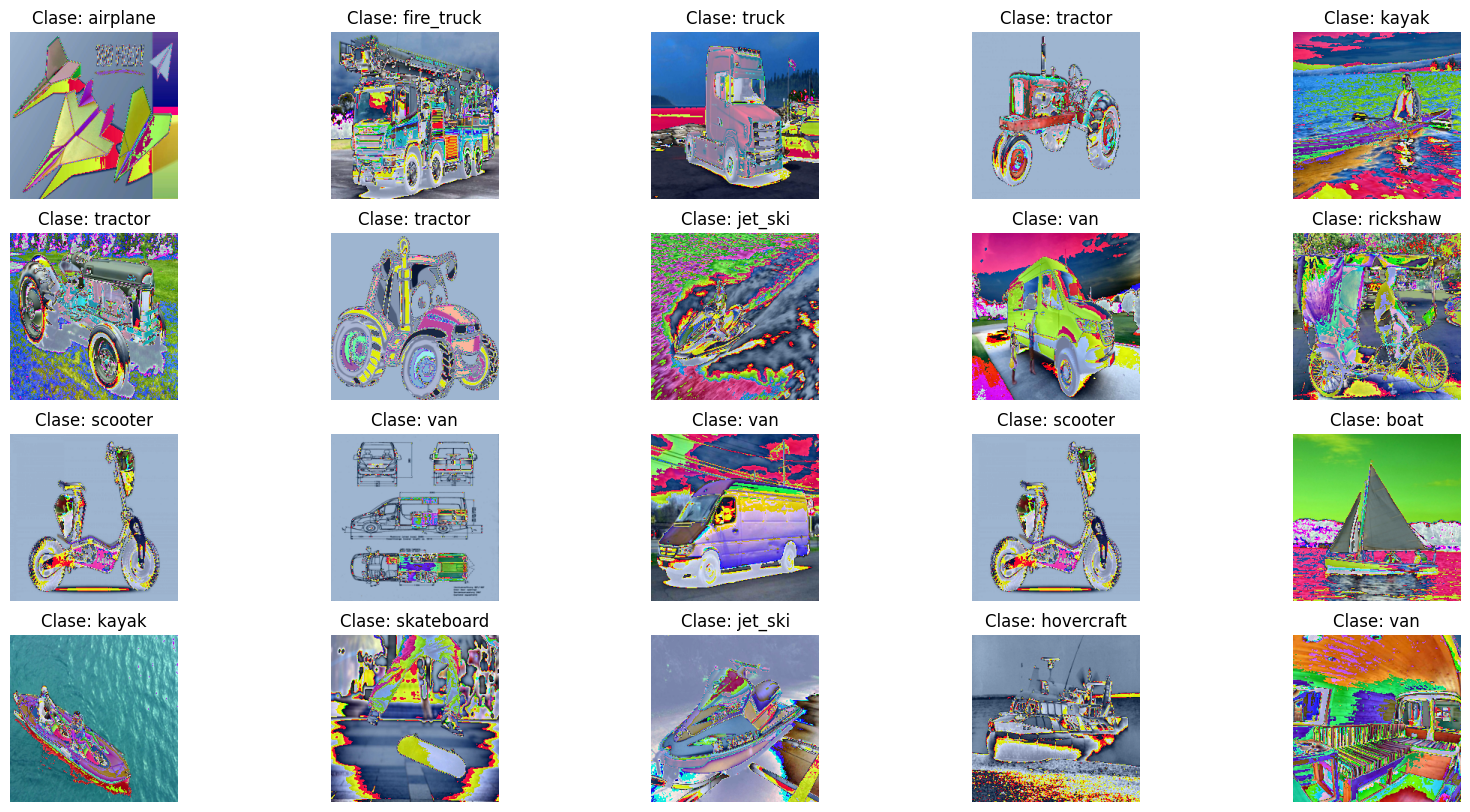

In [38]:
def tensor_to_image(tensor):
    '''Convierte un tensor a una imagen'''
    transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
        
    image = (transform(tensor) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
    return image

def tensor_to_image_gray(tensor):
    '''Convierte un tensor a una imagen en escala de grises'''
    transform = transforms.Compose([transforms.Normalize(mean = [ 0.], std = [1/0.5]), 
                                    transforms.Normalize(mean = [-0.5], std = [1])])
        
    image = (transform(tensor) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    return image

def visualizarPredicciones(data, class_names, num_images, num_rows, cmap = "color", cuda=False):
    '''Visualiza las predicciones de la red en un data_loader'''
    plt.figure(figsize=(20, 10))
    index = [random.randint(0, len(data)-1) for _ in range(num_images)]
    
    for i, idx in enumerate(index):
        image, label = data[idx]
        plt.subplot(num_rows, num_images//num_rows, i+1)

        if cuda and torch.cuda.is_available():
            image = image.cuda()

        if cmap == "gray":
            plt.imshow(tensor_to_image_gray(image), cmap='gray')
        else:
            plt.imshow(tensor_to_image(image), cmap='viridis')

        if class_names is not None:
            plt.title(f"Clase: {class_names[(label)]}")
        else:
            plt.title(f"Clase: {label}")
        plt.axis('off')

visualizarPredicciones(val_loader.dataset, class_names, num_images=20, num_rows=4, cmap = "gray", cuda=False)

In [ ]:
class NeuralNetwork(nn.Module): 
    def __init__(self):
        '''
        Construcción de la Red, define las capas que se utiizaran.
        '''
        super(NeuralNetwork, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)

    def forward(self, x):
        '''
        Define el orden con el que se realizará la propagación hacia adelante
        de la red.
        '''
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x 
    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una función de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza también el caso 
        en que se llegue a utilizar cuda. Muestra una gráfica al finalizar el
        entrenamiento usando el lost obtenido.
        ''' 
        losses = []

        if(cuda and torch.cuda.is_available()): 
            self.cuda()

        for epoch in range(epochs): 
            running_loss = 0.0

            for i, data in enumerate(data_loader, 0): 
                inputs, labels = data 

                if(cuda and torch.cuda.is_available()): 
                    inputs = inputs.cuda()
                    labels = labels.cuda() 

                optimizer.zero_grad() 
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward() 
                optimizer.step() 
                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.6f' % (epoch + 1, epoch_loss))
            
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()

RedNeuronal = NeuralNetwork()

criterio    = nn.CrossEntropyLoss()
optimizer   = optim.Adam(RedNeuronal.parameters(), lr=0.0001)

RedNeuronal.train(50,train_loader,criterio,optimizer,cuda=False)

prec_train = calcularPrecisionGlobal(RedNeuronal,train_loader,4)
prec_val   = calcularPrecisionGlobal(RedNeuronal,val_loader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

: 

In [ ]:
import numpy as np 
def predict(model, image, cuda = False): 
    if(cuda and torch.cuda.is_available()):
        image = image.cuda()

    if isinstance(image, torch.Tensor):
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
    else:
        npimg = image.numpy()

    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

    if not isinstance(image, torch.Tensor): 
        transform = transforms.Compose([
            transforms.toTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        image = transform(image)

    image = image.unsqueeze(0)

    with torch.no_grad(): 
        output = model(image)
        prob = F.softmax(output, dim=1)
        confidence, predicted = torch.max(prob, 1)
        confidence = confidence.item()
        predicted = predicted.item()

    print(f"Predicción: {labels[predicted]} (Confianza: {confidence*100:.2f}%)")
    return predicted, confidence

dataiter = iter(val_loader)
images, labels = dataiter.__next__()

for i in range(10): 
    predict(NeuralNetwork, images[i], cuda=False)
    print('Etiqueta real: %s' % labels[labels[i]])




In [ ]:
#Matriz de confusión	
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, data_loader, class_names, cuda=False):
    all_labels = []
    all_preds = []

    if(cuda and torch.cuda.is_available()): 
        model.cuda()

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            if(cuda and torch.cuda.is_available()): 
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)

# Initialize the model
model = NeuralNetwork()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train the model
model.train(epochs=5, data_loader=train_loader, criterion=criterion, optimizer=optimizer, cuda=False)
# Evaluate the model
evaluate_model(model, val_loader, class_names, cuda=False)
# Save the model
torch.save(model.state_dict(), 'vehicle_model.pth')


In [ ]:
# Load the model
model = NeuralNetwork()
model.load_state_dict(torch.load('vehicle_model.pth'))
# Evaluate the model
evaluate_model(model, val_loader, class_names, cuda=False)
# Predict on a single image
image, label = val_loader.dataset[0]
predict(model, image, cuda=False)
# Save the model
torch.save(model.state_dict(), 'vehicle_model.pth')
